# Predicting Taxa with Linear Regression

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.mixture import GaussianMixture
from sklearn import svm

from micropyome.taxa import regression

## Obtain Data

In [39]:
DATASET_PATH = "data/averill_processed/bacteria/"

In [40]:
datasets = {}
for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/15_variables.csv")
    if level == 'fg':
        y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    else:
        y = pd.read_csv(f"{DATASET_PATH}{level}/y_11groupTaxo.csv")

    x = x.drop(x.columns[0], axis=1)
    # x = StandardScaler().fit_transform(x)
    y = y.drop(y.columns[0], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    datasets[level] = {
        "x_train": x_train, "x_test": x_test,
        "y_train": y_train, "y_test": y_test
    }

In [41]:
datasets["fg"]["x_train"].head()

,latitude,longitude,depth_max,forest,map,map_sd,mat,mat_sd,map_CV,mat_CV,mdr,aridity,NPP,relEM,pH
1564,37.634000,-2.040000,7.5,0,0.368,0.050432,14.675000,1.305351,42.566848,687.113534,11.100000,0.412,0.513,0.972297,8.434
747,40.766890,-73.971500,5.0,0,1.210,0.046781,12.008333,1.281414,10.160729,893.353844,9.633333,0.969,0.736,0.581948,6.670
182,52.468993,-3.143635,15.0,1,1.274,0.047135,7.933333,1.232387,25.258205,415.256395,7.183333,1.863,0.649,0.871110,5.300
1332,41.183000,-104.900000,10.0,0,0.385,0.047060,7.508333,1.240701,55.682477,844.731883,15.633333,0.303,0.273,0.846238,7.000
631,40.774540,-73.972410,5.0,0,1.210,0.049223,12.008333,1.234854,10.160729,893.353844,9.633333,0.969,0.736,0.581948,7.380


In [42]:
datasets["fg"]["y_train"].head()

,other,assim_nitrate_reduction,assim_nitrite_reduction,cellulolytic,chitinolytic,copiotroph,denitrification,dissim_nitrate_reduction,dissim_nitrite_reduction,lignolytic,methanotroph,n_fixation,nitrification,oligotroph
1564,0.888146,0.001642,0.003810,0.004579,0.005256,0.025742,0.005579,0.005517,0.007255,0.003534,0.000212,0.007040,0.000166,0.041522
747,0.868608,0.005164,0.003516,0.003476,0.003408,0.050631,0.004771,0.009353,0.009176,0.001935,0.000305,0.009003,0.000934,0.029725
182,0.886892,0.002851,0.003005,0.003635,0.014334,0.032965,0.007328,0.004818,0.008190,0.000952,0.000200,0.004154,0.000927,0.029749
1332,0.841815,0.004766,0.005385,0.007823,0.005367,0.044924,0.011142,0.012526,0.012508,0.003339,0.000608,0.013354,0.001293,0.035153
631,0.882715,0.002278,0.003126,0.003701,0.013594,0.035472,0.006844,0.005352,0.008197,0.001228,0.000242,0.004085,0.000683,0.032481


## Create and Train Models

In [46]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor()),
}

In [47]:
results = {}
for model_name, model in models.items():
    results[model_name] = {}
    for level, dataset in datasets.items():
        model.fit(dataset["x_train"], dataset["y_train"])
        r = regression.evaluate(
            model, dataset["x_test"], dataset["y_test"],
            ignore="other", threshold=0.01
        )
        results[model_name][level] = np.mean(r)
    print(f"Evaluated the model `{model_name}`.")

Evaluated the model `Linear Regression`.
Evaluated the model `Decision Tree`.
Evaluated the model `Random Forest`.
Evaluated the model `Gradient Boosting`.


In [74]:
svms = []
for column in range(14):
    svms.append(svm.SVR())
    y = datasets["fg"]["y_train"].iloc[:, column].to_list()
    svms[-1].fit(datasets["fg"]["x_train"], y)

predictions = []
for i in range(len(datasets["fg"]["x_test"])):
    x = np.array(datasets["fg"]["x_test"].iloc[i].to_list()).reshape(1, -1)
    prediction = []
    for s in svms:
        prediction.append(s.predict(x))
    predictions.append(prediction)

d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
d:\stage\micropyome\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  w

In [90]:
pred = np.array(predictions)
pred = pred.T[0].T
r = regression.r2_score_by_column(datasets["fg"]["y_test"], pred)

In [91]:
r

[-2.714100537397803,
 -55.905008269586084,
 -23.31495619521323,
 -32.80773611233865,
 -34.555303246057676,
 -0.48132134813244054,
 -21.77995622345426,
 -18.95363968890075,
 -13.930742704305,
 -79.39955883473154,
 -39.187422910824324,
 -14.280325326406022,
 -170.31585636610714,
 -0.06627202540757549]

In [8]:
averill_results = pd.read_csv(f"{DATASET_PATH}/r2_published_results.csv")
published_results = averill_results.iloc[0].to_list()[1:]

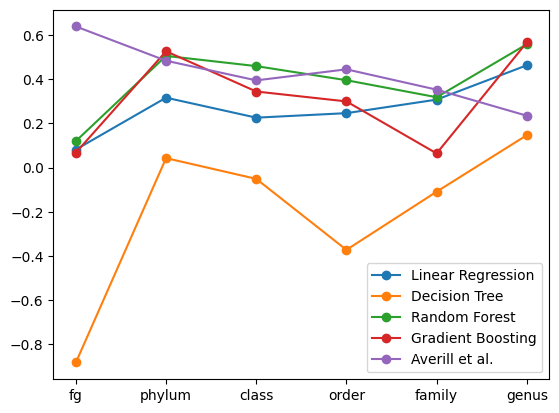

In [9]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in results:
    y = list(results[model].values())
    plt.plot(x, y, "-o", label=model)
plt.plot(x, published_results, "-o", label="Averill et al.")

plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

## Dirichlet Multivariate Regression Model

In [32]:
import arviz as az
import numpy as np
import pymc as pm
import scipy as sp

In [33]:
rng = np.random.default_rng(16)
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
trees = ["pine", "oak", "ebony", "rosewood", "mahogany"]  # Tree species observed
# fmt: off
forests = [  # Forests observed
    "sunderbans", "amazon", "arashiyama", "trossachs", "valdivian",
    "bosc de poblet", "font groga", "monteverde", "primorye", "daintree",
]
# fmt: on
k = len(trees)
n = len(forests)
total_count = 50

true_p = sp.stats.dirichlet(true_conc * true_frac).rvs(size=n, random_state=rng)
observed_counts = np.vstack(
    [sp.stats.multinomial(n=total_count, p=p_i).rvs(random_state=rng) for p_i in true_p]
)

observed_counts

array([[18, 19,  5,  8,  0],
       [ 6, 13,  4, 27,  0],
       [16, 21, 13,  0,  0],
       [18, 16,  1, 15,  0],
       [25, 15,  8,  2,  0],
       [16, 29,  4,  1,  0],
       [14, 15,  4, 17,  0],
       [10,  6, 30,  4,  0],
       [30,  8,  4,  8,  0],
       [16, 25,  5,  4,  0]], dtype=int64)

In [34]:
coords = {"tree": trees, "forest": forests}  # Input variables.
with pm.Model(coords=coords) as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")  # Expected fractions (i.e. output).
    counts = pm.Multinomial(
        "counts", n=total_count, p=frac, observed=observed_counts, dims=("forest", "tree")
    )

In [35]:
with model_multinomial:
    trace_multinomial = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


array([[<Axes: title={'center': 'frac'}>,
        <Axes: title={'center': 'frac'}>]], dtype=object)

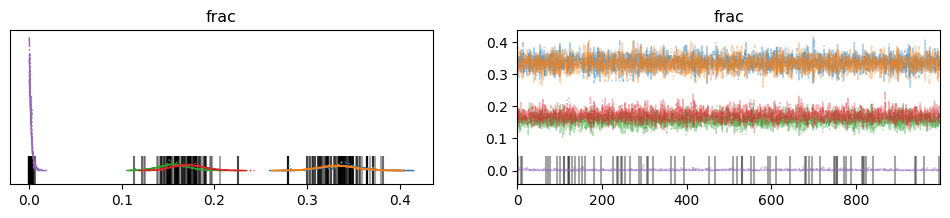

In [29]:
az.plot_trace(data=trace_multinomial, var_names=["frac"])

In [36]:
with model_multinomial:
    like = pm.compute_log_likelihood(trace_multinomial)

print(like)

Output()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


In [37]:
print(vars(like))

{'_groups': ['posterior', 'log_likelihood', 'sample_stats', 'observed_data'], '_groups_warmup': [], '_attrs': {}, 'posterior': <xarray.Dataset> Size: 164kB
Dimensions:  (chain: 4, draw: 1000, tree: 5)
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * tree     (tree) <U8 160B 'pine' 'oak' 'ebony' 'rosewood' 'mahogany'
Data variables:
    frac     (chain, draw, tree) float64 160kB 0.3529 0.3235 ... 0.1664 0.002933
Attributes:
    created_at:                 2024-05-10T03:20:29.231570+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.14.0
    sampling_time:              39.38974857330322
    tuning_steps:               1000, 'sample_stats': <xarray.Dataset> Size: 492kB
Dimensions:                (chain: 4, draw: 1000)
Coordinates:
  * chain                  (chain) int32 16B 0 1 2 3
  * draw                   (draw) int32 4kB 0 1 2 3 4 5 ...